In [71]:
# Imports for Project
import os
import numpy as np

Preparing Data

In [72]:
base_dir = os.getcwd()
data_path = f"{base_dir}/moredata/"
os.listdir(data_path)
print(data_path)

import joblib
from skimage.io import imread # loads an image from a file
from skimage.transform import resize # resizes an image to a particular size
 
def resize_all(src, pklname, include, width=227, height=227): # These should already be 227 pixels
     
    height = height if height is not None else width
     
    data = dict() #dictionary mapping
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path)[0:1300]:
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

c:\Users\colli\CompSci\PatternProject\CrackDetection/moredata/


In [73]:
# Resize all
base_name = 'GausNHogNOtsunValtest'
width = 227
include = {'Negative', 'Positive'}
resize_all(src=data_path, pklname=base_name, width=width, include=include)

from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

Negative
Positive
number of samples:  2600
keys:  ['label', 'filename', 'data']
image shape:  (227, 227, 3)
labels: ['Nega' 'Posi']


Counter({'Nega': 1300, 'Posi': 1300})

Split the dataset into 80 percent training and 20 percent testing

In [74]:
X = np.array(data['data'])
y = np.array(data['label'])
f = np.array(data['filename'])

from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test, f_train, f_test = train_test_split( #80 percent training, 20 percent testing data
    X, 
    y,
    f,  
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

Created Methods to Perform image transformation to every image

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from skimage.feature import canny
import skimage
import cv2 as cv
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])

class GaussianBlurTransformer():
    def __init__(self) -> None:
        pass

    def transform(self, X, y=None):
        return np.array([skimage.filters.gaussian(img, sigma=1.0) for img in X])
        # skimage.filters.gaussian(gray_image, sigma=1.0)
        
        

class ThresholdTransformer(): 
    def __init__(self) -> None:
        pass

    def regenerate_img(self, img, threshold):
        row, col = img.shape 
        y = np.zeros((row, col))
        for i in range(0,row):
            for j in range(0,col):
                if img[i,j] >= threshold:
                    y[i,j] = 1
                else:
                    y[i,j] = 0
        return y

    def transform(self, X, y=None):
        tempArr = []
        for img in X: 
            t = skimage.filters.threshold_otsu(img)
            img = self.regenerate_img(img, t)
            tempArr.append(img)
        return np.array(tempArr)
        #skimage.filters.threshold_otsu(blurred_image)

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

class CannyTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self) -> None:
        pass
 
    def transform(self, X, y=None):
        return np.array([canny(img, sigma=1) for img in X]) # 8 and 2 idk what they mean

class CannyTransformer2(BaseEstimator, TransformerMixin):
 
    def __init__(self) -> None:
        pass
 
    def transform(self, X, y=None):
        return np.array([cv.Canny((img*255).astype(np.uint8), 45, 250) for img in X]) # 8 and 2 idk what they mean

class LBPTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self) -> None:
        pass
 
    def transform(self, X, y=None):
        return np.array([local_binary_pattern(img, 8, 2, method = 'uniform') for img in X]) # 8 and 2 idk what they mean

Prepare the data by applying image transformations and HOG feature extraction

In [147]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
import cv2 as cv

grayify = RGB2GrayTransformer() # Grayscale
GBlur = GaussianBlurTransformer() # Gaussian Blur
TTrans = ThresholdTransformer() # Otsu
hogify = HogTransformer( 
    pixels_per_cell=(14, 14), #best 14,14
    cells_per_block=(4,4), #2,2 #best 4,4
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler() # Normalize
lbpify = LBPTransformer() 
cvcannyify = CannyTransformer2()

def prepareData(X_train, y_train):
    tempBinArr = []
    for p in range(len(y_train)):
        tempBinArr.append(str(y_train[p]))

    for l in range(len(tempBinArr)):
        if tempBinArr[l] == "Nega":
            tempBinArr[l] = 0
        else: 
            tempBinArr[l] = 1
    print('')
    y_train_binary = tempBinArr # This code needs to be uncommented if the feature selection is used
    X_train_gray = grayify.fit_transform(X_train)
    X_train_blur = GBlur.transform(X_train_gray)
    X_train_otsu = TTrans.transform(X_train_blur)
    X_train_hog = hogify.fit_transform(X_train_otsu) 
    X_train_scaled = scalify.fit_transform(X_train_hog)
    X_train_hogOTSU = SelectKBest(f_regression, k=2500).fit_transform(X_train_scaled, y_train_binary) # Uncommented if the feature selection
    X_train_prepared = X_train_hogOTSU #X_train_scaled
    X_train_canny = cvcannyify.transform(X_train_blur) # Uncomment to use Canny Edge Detection
    X_train_reshaped_canny = X_train_canny.reshape(X_train_canny.shape[0], X_train_canny.shape[1] * X_train_canny.shape[2]) # Uncomment to use Canny Edge Detection
    X_train_prepared = X_train_reshaped_canny # Uncomment to use Canny Edge Detection
    X_train_prepared = np.append(X_train_hogOTSU, X_train_reshaped_canny, axis=1)  # Uncomment to use Canny Edge Detection and HOG
    return X_train_prepared

X_train_prepared = prepareData(X_train, y_train)
X_test_prepared = prepareData(X_test, y_test)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


Print Cross Validation Accuracy of the Training Data
Create a Box Plot of the Cross Validation Accuracy

Cross Validation Accuracy -----------------------------------------------------------
On training data
[0.97115385 0.94951923 0.94711538 0.92788462 0.94951923]
Accuracy: 0.95 (+/- 0.03)
-------------------------------------------------------------------------------------


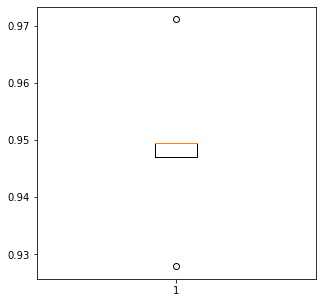

In [152]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

print('Cross Validation Accuracy -----------------------------------------------------------')
print('On training data')
svc_clf = SVC(gamma = 'scale', degree = 1)
svc_result = cross_validate(svc_clf, X_train_prepared, y_train) # Defaults to 5 cross folds
print(svc_result['test_score'])
print("Accuracy: %0.2f (+/- %0.2f)" % (svc_result['test_score'].mean(), svc_result['test_score'].std() * 2))
print('-------------------------------------------------------------------------------------')
fig = plt.figure(figsize =(5, 5))
 
# Creating plot
plt.boxplot(svc_result['test_score'])
 
# show plot
plt.show()



Train Data on Four Machine Learning Models using the Training Data:
    1. Stochastic Gradient Descent
    2. KMeans
    3. Logistic Regression
    4. Support Vector Classifier

In [153]:
from sklearn.linear_model import SGDClassifier #Stochastic Gradient Descent - incrementally trained logistic regression
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression #Logistic Regression is same as Stochastic Gradient Descent
from sklearn.svm import SVC

# Create ML Objects
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
kmeans = KMeans(n_clusters=4, random_state=42)
lr_clf = LogisticRegression(random_state=42)
svc_clf = SVC(gamma = 'scale', degree = 1) #auto and none

# Train Data
sgd_clf.fit(X_train_prepared, y_train)
kmeans.fit(X_train_prepared, y_train)
kmeans.labels_
lr_clf.fit(X_train_prepared, y_train)
svc_clf.fit(X_train_prepared, y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(degree=1)

Use models to predict on the new test Dataset
Prints the performance of the models on the new test data
Prints a Confusion Matrix of data misclassified by the SVC

Testing Accuracy-----------------------------------------------------------

Percentage correct Stochastic Gradient Descent:  88.65384615384616

Percentage correct KMeans:  51.15384615384615

Percentage correct Logistic Regression:  93.07692307692308

Percentage correct Support Vector Classifier:  96.15384615384616

-------------------------------------------------------------------------


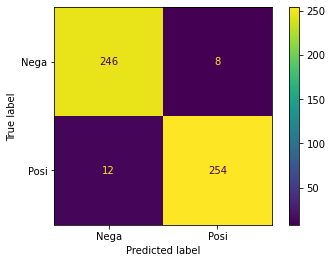

In [154]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

print('Testing Accuracy-----------------------------------------------------------')

y_pred = sgd_clf.predict(X_test_prepared)
print('')
print('Percentage correct Stochastic Gradient Descent: ', 100*np.sum(y_pred == y_test)/len(y_test))

ky_pred = kmeans.predict(X_test_prepared)
tempArr = []
for p in range(len(ky_pred)):
    tempArr.append(str(ky_pred[p]))

for l in range(len(tempArr)):
    if tempArr[l] == "0":
        tempArr[l] = "Posi"
    else: 
        tempArr[l] = "Nega"
print('')
print('Percentage correct KMeans: ', 100*np.sum(tempArr == y_test)/len(y_test))

lr_pred = lr_clf.predict(X_test_prepared)
print('')
print('Percentage correct Logistic Regression: ', 100*np.sum(lr_pred == y_test)/len(y_test))

svc_pred = svc_clf.predict(X_test_prepared)
print('')
print('Percentage correct Support Vector Classifier: ', 100*np.sum(svc_pred == y_test)/len(y_test))

print('')
print('-------------------------------------------------------------------------')

cm = confusion_matrix(y_test, svc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= svc_clf.classes_)
disp.plot() # Prints confusion matrix for only SVC

The following code is used to identify misclassified images

In [155]:
import matplotlib.pyplot as plt
import skimage.io

base_dir = os.getcwd()
data_path = f"{base_dir}/moredata/"
os.listdir(data_path)
print(data_path)
negative_path = os.path.join(data_path, 'Negative')
positive_path = os.path.join(data_path, 'Positive')

int = 0
for x in y_test:
    if x != svc_pred[int]:
        if x == 'Nega':
            print("Wrongly Classified as Crack: ")
            print(int)
            print(f_test[int])
        else:
            print("Wrongly Classified as NO C: ")
            print(int)
            print(f_test[int])
    int = int + 1


c:\Users\colli\CompSci\PatternProject\CrackDetection/moredata/
Wrongly Classified as NO C: 
5
00635.jpg
Wrongly Classified as Crack: 
29
01118.jpg
Wrongly Classified as Crack: 
88
01270.jpg
Wrongly Classified as NO C: 
115
00295.jpg
Wrongly Classified as Crack: 
155
00565.jpg
Wrongly Classified as Crack: 
158
00811.jpg
Wrongly Classified as NO C: 
232
01042.jpg
Wrongly Classified as NO C: 
263
00975.jpg
Wrongly Classified as Crack: 
304
00742.jpg
Wrongly Classified as NO C: 
313
00056.jpg
Wrongly Classified as NO C: 
330
00651.jpg
Wrongly Classified as NO C: 
351
00192.jpg
Wrongly Classified as Crack: 
361
00180.jpg
Wrongly Classified as NO C: 
399
00065.jpg
Wrongly Classified as NO C: 
416
00650.jpg
Wrongly Classified as Crack: 
419
00354.jpg
Wrongly Classified as NO C: 
441
00181.jpg
Wrongly Classified as NO C: 
447
00952.jpg
Wrongly Classified as NO C: 
483
00276.jpg
Wrongly Classified as Crack: 
488
00441.jpg


The misclassified image from the previous code block can be manually visually inspected using the code block below

Wrongly Classified as Crack Image: 
00818.jpg


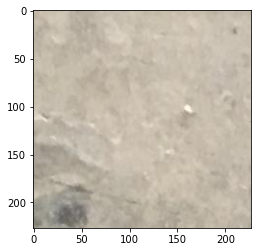

In [156]:
# This code prints the misclassified pictures to screen
#bet
imageNumber = 380
file = f_test[imageNumber]
decision = True
if decision == True: 
    print("Wrongly Classified as Crack Image: ")
    image = skimage.io.imread(os.path.join(negative_path, file))
    plt.imshow(image)
    print(file)
else:
    print("Wrongly Classified as NO Crack Image: ")
    image = skimage.io.imread(os.path.join(positive_path, file))
    plt.imshow(image)
    print(file)